In [240]:
import sys
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import seaborn as sns
from scipy.stats import chi2_contingency
import plotly.graph_objs as go

# Cleaning up Data

In [241]:
data = pd.read_csv("../data/raw/raw.csv")

In [242]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Examining the data and the variables involved is the first priority before continuing with anything else. For first glance is seems that more of the variables are categorical. The first thing I noticed about the categorical variables is that some variables like "SeniorCitizen" is recorded in binary integers while variables like "Partner" and "Dependents" are object type. For now I am not going to standardize the types until right before the modelling phase

In [243]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Looking at the value types for the features in the dataset the one thing that stands out is that TotalCharges is an object instead of a int or a float

In [244]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"],errors='coerce')

In [245]:
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

After changing the type of "TotalCharges" to a float, we can see that there are 11 missing values

In [246]:
data["TotalCharges"] = data["TotalCharges"].fillna(data["TotalCharges"].mean())

In [247]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

After imputing the missing values with the mean value for TotalCharges, there are no more missing values in the dataset

# Exploring features and their relationships

<AxesSubplot:>

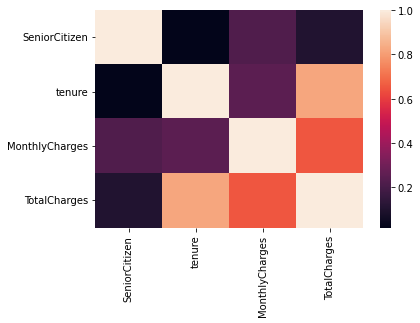

In [248]:
sns.heatmap(data.corr())

When looking at the correlations between the numeric features, realistically it seems that only TotalCharges and MonthlyCharges are correlated as it would only make sense since MonthlyCharges contribute the the size of TotalCharges

The objective is identify the variables affecting the rate of churn. When looking at the effects of churn, I will develop a general hypothesis. My hypothesis is that features such as the monthly charges, tenure, the type of service the subject is contracted are going to be important to the contributing to churn. So I will perform some EDA on those features. I will be performing the EDA on churned users and looking at the length of their tenure as if we compare active vs churned users, there could be active users who have just started their contract and could decide to drop their contract soon and therefore comparing the features against active vs churned users will give us a non-representative idea of the features.

In [249]:
def is_normal(group):
    #Checks if an array of values is normally distributed using Shapiro-Wilkes Test
    #Null hypothesis is that data was sampled from normal distribution
    tstat, pval = stats.shapiro(group)
    if len(group) > 5000: #Test statistics more accurate for larger set
        if tstat < 0.05: 
            return False
    if pval < 0.05: 
        return False
    return True

def eq_var(group1, group2):
    #Check that property of homoscedacity (equal Variance) using Levene Test
    _, pval = stats.levene(group_1, group_2) 
    if pval < 0.05: return False
    return True

def stat_test(group1, group2):
    """Between 2 groups, if the conditions of normality + homoscendacity hold, perform 
    T-Test, otherwise perform the Mann Whiteny U Test."""
    
    if is_normal(group1) and is_normal(group2):
        if eq_var(group1, group2):
            print("Performing T-Test ...")
            return stats.ttest_ind(group1,group2)
        print("Performing T-Test with unequal variance")
        return stats.ttest_ind(group1,group2, equal_var = False)
    print("Performing U-Test ...")
    return mannwhitneyu(group1, group2)

In [250]:
def ChiSquareTest(table, prob = 0.95):
    stat, pval, dof, expected = chi2_contingency(table)
    alpha = 1 - prob
    if pval <= alpha:
        print('Dependence between two categorical variables, reject H0')
    else:
        print('Independence between two categorical variables, fail to reject H0')
                       

In [251]:
data['MonthlyChargesRange'] = pd.qcut(data['MonthlyCharges'], q=5)

In [252]:
data['MonthlyChargesRange'] = data['MonthlyChargesRange'].astype(str)

In [253]:
conditions = [(data['PhoneService'] == 'Yes') & ((data["InternetService"] == 'Fiber optic') | (data["InternetService"] =='DSL')),
               (data['PhoneService'] == 'Yes') & (data['InternetService'] == 'No'),
              (data['PhoneService'] == 'No') & ((data["InternetService"] == 'Fiber optic') | (data["InternetService"] =='DSL')),
              (data['PhoneService'] == 'No') & (data['InternetService'] == 'No')]
values = ["Internet & Phone", "Phone Only", "Internet Only", "Neither"]

In [254]:
data['InternetPhoneService'] = np.select(conditions, values)

I created a new column called InternetPhoneService that represents whether a customer had Internet Service, Phone service or both. This new feature will help me visualize if having either service or both has an effect on tenure and churn

In [255]:
data['MonthlyChargesRange'].value_counts()

(18.249, 25.05]    1420
(58.83, 79.1]      1411
(94.25, 118.75]    1408
(79.1, 94.25]      1407
(25.05, 58.83]     1397
Name: MonthlyChargesRange, dtype: int64

In [256]:
churned_users = data[data["Churn"] == "No"]
active_users = data[data.Churn == "Yes"]

In [257]:
DF1 =  churned_users.groupby('MonthlyChargesRange').mean()["tenure"]

DF1 represents the mean tenure for each range of monthly charge for churned users. I have decided to use only churned users when comparing tenure length because the nature of active users is that there contract is still running and therefore I felt it would be misrepresentative to compare the tenure lengths when they are still ongoing and the values could change

In [258]:
px.bar(DF1, title = "Average Tenure for Ranges of Monthly Charges")

From the chart it is quite clear that as the Monthly Charges increase, the average tenure for a churned customer increases to . However from /$18 to \$58 there is not much of a change but after the threshold of $58, tenure starts to significantly increase

In [259]:
DF2 = churned_users.groupby('Contract').mean()["tenure"]

In [260]:
px.bar(DF2, title = 'Average contract tenure among churned users of different contract types')

In [261]:
contractChurnTable = pd.crosstab(data.Contract, data.Churn)
contractChurnTable

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


In [262]:
ChiSquareTest(contractChurnTable)

Dependence between two categorical variables, reject H0


Looking at the graph, we can see that ,among churned users, contracts of longer length correspond to longer tenures. I decide to use the chisquare test to find evidence that there is some dependence between contract type and churn. The test concludes that there is dependence between contract type and churn and this gives me confidence that contract type will be an important feature to include in the modelling later.

In [263]:
DF3 = churned_users.groupby(["MonthlyChargesRange", "Contract"]).count()["customerID"]
DF3 = DF3.reset_index()
DF3 = DF3.rename(columns = {"customerID" : "count"})

In [264]:
px.bar(DF3, x = "MonthlyChargesRange", y = "count", color = "Contract" , barmode = "group")

For the graph above I manipulated the data using the groupby function in order to explore the relationship between the Monthly Charges and contract type. However it does not seem like there is any relationship

In [265]:
px.pie(data, names = 'InternetPhoneService', title ='Distribution of Service Plans among Customers')

In [266]:
px.pie(active_users, names = 'InternetPhoneService', title ='Distribution of Service Plans among Active Customers')

In [267]:
px.pie(churned_users, names = 'InternetPhoneService', title ='Distribution of Service Plans among Churned Customers')

In [268]:
fig = go.Figure()
fig.add_trace(
    go.Box(y = churned_users['tenure'][churned_users['InternetPhoneService'] == "Internet Only"], name = "Internet")
    )
fig.add_trace(
    go.Box(y = churned_users['tenure'][churned_users['InternetPhoneService'] == "Phone Only"], name = "Phone")
    )
fig.add_trace(
    go.Box(y = churned_users['tenure'][churned_users['InternetPhoneService'] == "Internet & Phone"], name = "Both")
    )

Customers with both internet and phone plans seem to have a greater distribution for active customers vs churned customers, while customers with either internet or phone plans have a greater distribution in churned customers, espeically customers with only phone plans which make up 27% of churned users against 9% in active users. When comparing the distribution of tenure among churned users with the three types of plans, tenure for customers with only phone plans had the lowest median value at 28 months, followed by customers with only internet plans and then customers with both. It seems pretty clear from the evidence that the type of plans has an effect on whether customers churn and how long they stay with their contract and that customers with only a phone plan are much more likely to churn.

# Modelling

In [309]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

In [321]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgb

In [271]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyChargesRange,InternetPhoneService
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,"(25.05, 58.83]",Internet Only
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,"(25.05, 58.83]",Internet & Phone
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,"(25.05, 58.83]",Internet & Phone
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,"(25.05, 58.83]",Internet Only
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,"(58.83, 79.1]",Internet & Phone


I am going to be using three gradient boosting models: XGBoost, CatBoost and LightGBM. Catboost and LightGBM differ from XGBoost in that they do not require categorical variables to be encoded numerically which is a convinient feature. However since I am also going to be using XGBoost I will encode the categorical variables in the dataset, first by converting yes,no categorical features into binary and then using dummy encoding for categorical features with more than two categories. 

In [272]:
data = data.drop('customerID', axis = 1)

In [273]:
data = data.drop(['PhoneService','InternetService',"MonthlyChargesRange"], axis = 1)

In [274]:
dataEncoded = data.copy()

In [275]:
dataEncoded.head()
BinaryCatColumns = ['Partner', 'Dependents','PaperlessBilling','Churn']



In [276]:
for col in BinaryCatColumns:
    dataEncoded[col] = dataEncoded[col].map({'Yes': 1, 'No' : 0})
    #dataEncoded[col] = dataEncoded[col].astype('int32')

In [277]:
for col in BinaryCatColumns:
    dataEncoded[col] = dataEncoded[col].astype('int32')

In [278]:
dataEncoded = pd.get_dummies(dataEncoded)

In [279]:
y = dataEncoded['Churn']
X = dataEncoded.drop("Churn", axis = 1)

First I will fit the XGBoost model. The dataset needs to be split into train and test data and this will be done using the Sklearn train_test_split function

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 40)

In [281]:
#parameter grid for XGboost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [282]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [284]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   25.7s finished
/Users/avinaashpadman/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:41:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f9c2a140bf8>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsa

In [285]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [289]:
y_hat = random_search.predict(X_test)

In [297]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

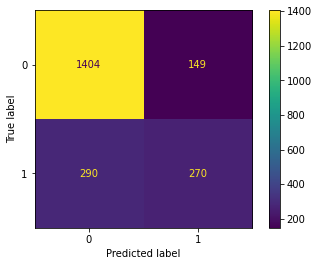

In [296]:
plot_confusion_matrix(random_search, X_test, y_test)

In [298]:
print(classification_report(y_test,y_hat))

(array([0.82880756, 0.64439141]),
 array([0.90405666, 0.48214286]),
 array([0.86479828, 0.55158325]),
 array([1553,  560]))

When evaluating the performance of the model, its important to identify what the goal of the model should be. Our goal is create a model that identifies when a customer is likely to churn (true positives). Ideally our model should also correctly identify customers who are not likely to churn such that resources wont be wasted on them but thats not the priority. Therefore we want to look at metrics like recall (or sensitivity) which is the true positive rate or the rate at which customers that should be labelled as likely to churn as correctly labelled as likely to churn. The recall for this model is 0.48 which is quite bad and when we look at the confusion matrix out of all the customer who were supposed to churn (560), only 270 were correctly labelled, while 290 were false negatives. 

In [ ]:
params = {
    'depth' : [1,2,3,4,5,6,7,8],
    'iterations' : [100, 200, 500, 1000,2000]
    'learning_rate': [0.01,0.02, 0.005, 0.001]
    '12_leaf_reg': [1,3,5,10,50]
    'border_count' : [5,10,20,35,50,100]
    'ctr_border_count': [5, 10,20,50]
}

In [304]:
cat_clf = cb.CatBoostClassifier()
cat_clf.fit(X_train,y_train)
y_hat = cat_clf.predict(X_test)

Learning rate set to 0.02036
0:	learn: 0.6785581	total: 5.73ms	remaining: 5.72s
1:	learn: 0.6652219	total: 11.7ms	remaining: 5.84s
2:	learn: 0.6523857	total: 15.8ms	remaining: 5.25s
3:	learn: 0.6399817	total: 20.1ms	remaining: 5s
4:	learn: 0.6283197	total: 24.2ms	remaining: 4.81s
5:	learn: 0.6179186	total: 28.6ms	remaining: 4.73s
6:	learn: 0.6070042	total: 32.2ms	remaining: 4.56s
7:	learn: 0.5975871	total: 37.4ms	remaining: 4.64s
8:	learn: 0.5888484	total: 44.4ms	remaining: 4.88s
9:	learn: 0.5803725	total: 49.2ms	remaining: 4.88s
10:	learn: 0.5716886	total: 57.4ms	remaining: 5.16s
11:	learn: 0.5639330	total: 63.2ms	remaining: 5.2s
12:	learn: 0.5566779	total: 67.1ms	remaining: 5.1s
13:	learn: 0.5495668	total: 70.5ms	remaining: 4.96s
14:	learn: 0.5427910	total: 78.2ms	remaining: 5.14s
15:	learn: 0.5364197	total: 82.6ms	remaining: 5.08s
16:	learn: 0.5296928	total: 85.7ms	remaining: 4.96s
17:	learn: 0.5238054	total: 88.5ms	remaining: 4.83s
18:	learn: 0.5182852	total: 91.6ms	remaining: 4.73

162:	learn: 0.3813395	total: 571ms	remaining: 2.93s
163:	learn: 0.3812045	total: 575ms	remaining: 2.93s
164:	learn: 0.3809227	total: 580ms	remaining: 2.93s
165:	learn: 0.3806845	total: 584ms	remaining: 2.93s
166:	learn: 0.3804825	total: 588ms	remaining: 2.93s
167:	learn: 0.3803172	total: 592ms	remaining: 2.93s
168:	learn: 0.3801729	total: 595ms	remaining: 2.93s
169:	learn: 0.3799228	total: 599ms	remaining: 2.92s
170:	learn: 0.3797813	total: 604ms	remaining: 2.93s
171:	learn: 0.3796378	total: 607ms	remaining: 2.92s
172:	learn: 0.3794957	total: 610ms	remaining: 2.92s
173:	learn: 0.3792211	total: 613ms	remaining: 2.91s
174:	learn: 0.3790886	total: 616ms	remaining: 2.9s
175:	learn: 0.3788729	total: 619ms	remaining: 2.9s
176:	learn: 0.3786784	total: 622ms	remaining: 2.89s
177:	learn: 0.3785149	total: 625ms	remaining: 2.88s
178:	learn: 0.3782863	total: 628ms	remaining: 2.88s
179:	learn: 0.3781807	total: 631ms	remaining: 2.87s
180:	learn: 0.3780084	total: 633ms	remaining: 2.87s
181:	learn: 0.

333:	learn: 0.3556547	total: 1.14s	remaining: 2.28s
334:	learn: 0.3555856	total: 1.15s	remaining: 2.27s
335:	learn: 0.3554825	total: 1.15s	remaining: 2.27s
336:	learn: 0.3553451	total: 1.16s	remaining: 2.27s
337:	learn: 0.3551583	total: 1.16s	remaining: 2.27s
338:	learn: 0.3550775	total: 1.17s	remaining: 2.27s
339:	learn: 0.3549096	total: 1.17s	remaining: 2.27s
340:	learn: 0.3547869	total: 1.17s	remaining: 2.27s
341:	learn: 0.3546292	total: 1.18s	remaining: 2.27s
342:	learn: 0.3543713	total: 1.18s	remaining: 2.26s
343:	learn: 0.3542963	total: 1.18s	remaining: 2.26s
344:	learn: 0.3541315	total: 1.19s	remaining: 2.25s
345:	learn: 0.3539904	total: 1.19s	remaining: 2.25s
346:	learn: 0.3538040	total: 1.19s	remaining: 2.25s
347:	learn: 0.3537005	total: 1.2s	remaining: 2.24s
348:	learn: 0.3536127	total: 1.2s	remaining: 2.24s
349:	learn: 0.3534535	total: 1.2s	remaining: 2.23s
350:	learn: 0.3533219	total: 1.2s	remaining: 2.23s
351:	learn: 0.3532266	total: 1.21s	remaining: 2.22s
352:	learn: 0.35

512:	learn: 0.3332562	total: 1.72s	remaining: 1.63s
513:	learn: 0.3330174	total: 1.72s	remaining: 1.63s
514:	learn: 0.3328918	total: 1.73s	remaining: 1.62s
515:	learn: 0.3327707	total: 1.73s	remaining: 1.62s
516:	learn: 0.3326771	total: 1.74s	remaining: 1.62s
517:	learn: 0.3325688	total: 1.74s	remaining: 1.62s
518:	learn: 0.3324832	total: 1.74s	remaining: 1.62s
519:	learn: 0.3323391	total: 1.75s	remaining: 1.62s
520:	learn: 0.3322389	total: 1.76s	remaining: 1.61s
521:	learn: 0.3320980	total: 1.76s	remaining: 1.61s
522:	learn: 0.3320138	total: 1.78s	remaining: 1.63s
523:	learn: 0.3318738	total: 1.79s	remaining: 1.63s
524:	learn: 0.3318014	total: 1.79s	remaining: 1.62s
525:	learn: 0.3316854	total: 1.8s	remaining: 1.62s
526:	learn: 0.3315711	total: 1.8s	remaining: 1.61s
527:	learn: 0.3314639	total: 1.8s	remaining: 1.61s
528:	learn: 0.3313385	total: 1.81s	remaining: 1.61s
529:	learn: 0.3312086	total: 1.81s	remaining: 1.6s
530:	learn: 0.3310005	total: 1.82s	remaining: 1.61s
531:	learn: 0.33

697:	learn: 0.3132324	total: 2.65s	remaining: 1.15s
698:	learn: 0.3131327	total: 2.66s	remaining: 1.14s
699:	learn: 0.3130501	total: 2.66s	remaining: 1.14s
700:	learn: 0.3129010	total: 2.67s	remaining: 1.14s
701:	learn: 0.3127998	total: 2.67s	remaining: 1.14s
702:	learn: 0.3127024	total: 2.68s	remaining: 1.13s
703:	learn: 0.3126705	total: 2.69s	remaining: 1.13s
704:	learn: 0.3125602	total: 2.69s	remaining: 1.13s
705:	learn: 0.3124934	total: 2.7s	remaining: 1.12s
706:	learn: 0.3124126	total: 2.7s	remaining: 1.12s
707:	learn: 0.3122637	total: 2.71s	remaining: 1.12s
708:	learn: 0.3121852	total: 2.71s	remaining: 1.11s
709:	learn: 0.3121257	total: 2.72s	remaining: 1.11s
710:	learn: 0.3120310	total: 2.72s	remaining: 1.1s
711:	learn: 0.3119568	total: 2.72s	remaining: 1.1s
712:	learn: 0.3118693	total: 2.73s	remaining: 1.1s
713:	learn: 0.3117797	total: 2.73s	remaining: 1.09s
714:	learn: 0.3117175	total: 2.74s	remaining: 1.09s
715:	learn: 0.3116444	total: 2.75s	remaining: 1.09s
716:	learn: 0.311

876:	learn: 0.2952539	total: 3.59s	remaining: 504ms
877:	learn: 0.2951587	total: 3.6s	remaining: 500ms
878:	learn: 0.2950661	total: 3.6s	remaining: 496ms
879:	learn: 0.2949528	total: 3.61s	remaining: 492ms
880:	learn: 0.2948678	total: 3.61s	remaining: 488ms
881:	learn: 0.2947287	total: 3.62s	remaining: 485ms
882:	learn: 0.2946530	total: 3.63s	remaining: 481ms
883:	learn: 0.2946138	total: 3.63s	remaining: 477ms
884:	learn: 0.2945363	total: 3.64s	remaining: 473ms
885:	learn: 0.2944681	total: 3.65s	remaining: 469ms
886:	learn: 0.2943263	total: 3.65s	remaining: 465ms
887:	learn: 0.2942066	total: 3.65s	remaining: 461ms
888:	learn: 0.2941083	total: 3.66s	remaining: 457ms
889:	learn: 0.2940248	total: 3.66s	remaining: 453ms
890:	learn: 0.2939234	total: 3.66s	remaining: 448ms
891:	learn: 0.2938388	total: 3.67s	remaining: 444ms
892:	learn: 0.2937488	total: 3.67s	remaining: 440ms
893:	learn: 0.2936536	total: 3.68s	remaining: 436ms
894:	learn: 0.2935804	total: 3.68s	remaining: 432ms
895:	learn: 0.

In [305]:
accuracy_score(y_test,y_hat)

0.7827733080927591

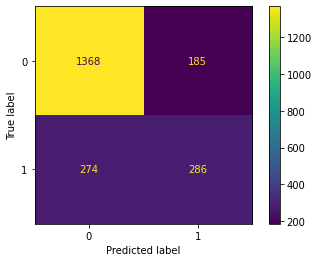

In [307]:
plot_confusion_matrix(cat_clf, X_test, y_test)

In [311]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1553
           1       0.61      0.51      0.55       560

    accuracy                           0.78      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.77      0.78      0.78      2113



After fitting a Catboost classifier, we see a slight improvement to recall from 0.48 to 0.51 as the number of true positives increase from 270 to 286 . However precision has dropped from 0.64 to 0.61 as the model is predicting more false positives, customers who haven't churned but were predicted to churn. Since I had decided to prioritise recall given the assumption that identifying customers who are likely to churn would be more financially beneficial to the "business", Catboost seems to be a better model.


# Model Interpretation

In order to be able to intepret the importance the Catboost model is giving to each feature we will use a model called shap that utilises shapley values to show the weight that each feature has on predicting a label. It is important to be able to know how a model places importance on a feature so that we can drop irrelavant features to speed up our model training during deployment and to be backup the hypothesis made during the data exploration, such as whether contract type does have a significant effect on churn

In [323]:
shap_values = cat_clf.get_feature_importance(cb.Pool(X_test, label = y_test), type = "ShapValues")

In [324]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [325]:
import shap

In [326]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

For the above image, the shapley values of each feature are shown for a given test samples, namely the sample corresponding to index 3 of the test data. We see that "tenure", "monthlyCharges" and Contract type are features that have a large weight over the prediction for sample 3. This lines up with the data analysis done previously that identified those features are being important

In [327]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

In [331]:
explainer = shap.Explainer(cat_clf, X_train)
shap_values = explainer(X_test)

100%|===================| 2106/2113 [01:43<00:00]        

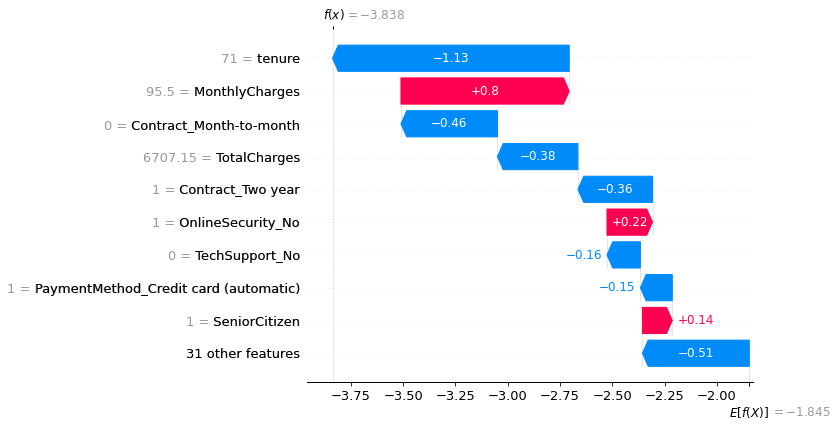

In [332]:
shap.plots.waterfall(shap_values[0])

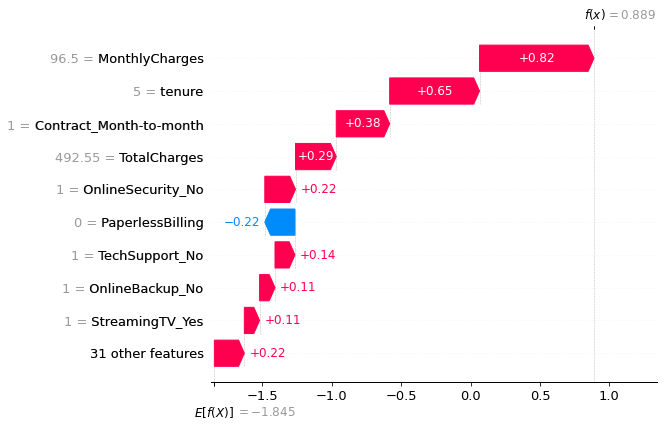

In [338]:
shap.plots.waterfall(shap_values[1])

A waterfall bar chart is another way of visualizing the feature importance. Again this is only looking at an individual sample. $E[f(x)]$ represents the value predicted if we did not know any of the features, or the mean value of all the y test labels. F(x) should be a probability but for binary classification SHAP values are displayed in logit space. However this is not too important as all we need to know is that a greater SHAP value suggests a larger contribution by the feature to the model output

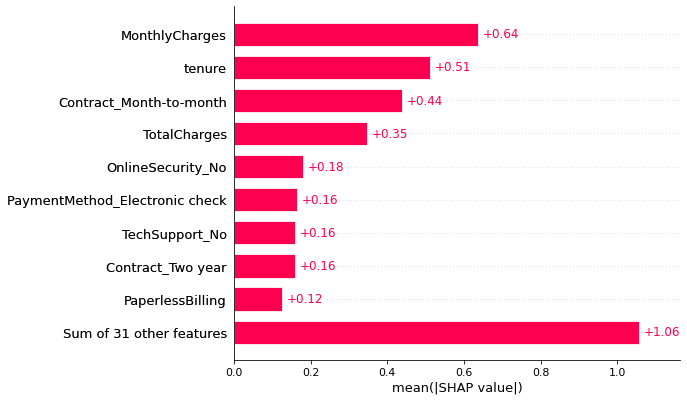

In [333]:
shap.plots.bar(shap_values)

The graph above shows the mean absolute SHAP values for each feature across the whole dataset. According to this graph MonthlyCharges, Tenure and having a month-to-month contract were the three biggest contributing features to customer churn.  